In [1]:
spark

In [2]:
import json
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.regression import LinearRegressionWithSGD
import matplotlib.pyplot as plt
from pyspark.mllib.util import MLUtils
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.feature import StandardScaler
from pyspark.sql import Row
from pandas import *


print("START................................................................................................")

df = spark.read.parquet("/corpora/corpora-thirdparty/corpora-reddit/all-submissions.parquet")

df_filter = df.filter(df['subreddit'] == 'Jokes')

df_select = df_filter.select(df_filter['score'], df_filter['title'], df_filter['selftext']) #, df_filter['over_18'])

pandas_df = df_select.toPandas()

data_titles = pandas_df.title.str.split(" ")
data_selftext = pandas_df.selftext.str.split(" ")

print(data_titles,"\n")
print(data_selftext, "\n")

START................................................................................................
0                              [The, Old, Soldier's, Home.]
1         [You, thought, you, had, your, first, pubic, h...
2                                         [Just, tasteless]
3         [How, do, you, invite, somebody, to, participa...
4         [Man, A:, Would, you, suck, my, cock, if, I, c...
5         [I, came, home, to, a, man, going, down, on, m...
6         [How, do, you, Keep, Your, Couch, Potato, off,...
7             [Why, are, you, such, a, miserable, asshole?]
8         [Hey, sexy, mama,, can, I, be, your, derivative?]
9                 [How, do, you, make, a, cat, go, "meow"?]
10        [What, did, the, sadist, do, to, the, masochist?]
11              [What, do, you, call, a, male, camel, toe?]
12                   [Man, A:, Where, did, you, get, that?]
13           [I, once, lived, opposite, a, slaughterhouse.]
14        [So, a, father's, son, is, going, to, college...

In [5]:
df.columns

['adserver_click_url',
 'adserver_imp_pixel',
 'approved',
 'approved_at_utc',
 'approved_by',
 'archived',
 'author',
 'author_cakeday',
 'author_flair_background_color',
 'author_flair_css_class',
 'author_flair_richtext',
 'author_flair_text',
 'author_flair_text_color',
 'author_flair_type',
 'author_id',
 'ban_note',
 'banned_at_utc',
 'banned_by',
 'brand_safe',
 'can_gild',
 'can_mod_post',
 'clicked',
 'contest_mode',
 'created',
 'created_utc',
 'crosspost_parent',
 'crosspost_parent_list',
 'disable_comments',
 'distinguished',
 'domain',
 'domain_override',
 'downs',
 'edited',
 'embed_type',
 'embed_url',
 'events',
 'eventsOnRender',
 'from',
 'from_id',
 'from_kind',
 'gilded',
 'hidden',
 'hide_score',
 'href_url',
 'id',
 'ignore_reports',
 'imp_pixel',
 'is_blank',
 'is_crosspostable',
 'is_original_content',
 'is_reddit_media_domain',
 'is_self',
 'is_video',
 'likes',
 'link_flair_background_color',
 'link_flair_css_class',
 'link_flair_richtext',
 'link_flair_templa

In [3]:
df.groupBy("subreddit").count().show()

+--------------------+------+
|           subreddit| count|
+--------------------+------+
|              travel|536416|
|           Fairbanks|  1563|
|               anime|414693|
|          MensRights|179643|
|        marvelheroes| 25456|
|         muhfreedoms|   112|
|     NOTSONEWREDDITS|  3722|
|     Sexy3DAnimation|   324|
|             jewelry| 22427|
|          QuotesPorn| 34440|
|      TrueOffMyChest| 16686|
|         creepypasta| 16622|
|              botony|    42|
|             Amateur| 85965|
|          WahoosTipi| 13914|
|          electrical|  6769|
|RepulicOTueAllReb...|    45|
|                 VCH|     6|
|      DunedinFlorida|   187|
|       dentonbuysell|   165|
+--------------------+------+
only showing top 20 rows



In [26]:
print("Total Jokes\n",pandas_df.count())

print("\nTotal corpus\n",df.count())

Total Jokes
 score       581250
title       581250
selftext    581250
dtype: int64

Total corpus
 399421538


In [23]:
df.describe('score').show()

+-------+------------------+
|summary|             score|
+-------+------------------+
|  count|         399421538|
|   mean|   31.962264280801|
| stddev|442.67651108010665|
|    min|                 0|
|    max|            270469|
+-------+------------------+



In [26]:
df_select.describe('score').show()

+-------+-----------------+
|summary|            score|
+-------+-----------------+
|  count|           581250|
|   mean|84.25789075268817|
| stddev|987.2982631018587|
|    min|                0|
|    max|            95020|
+-------+-----------------+



In [27]:
df_select.filter(df_select['score']>200).count()

25350

In [35]:
df_select.filter(df_select['score']>500).count()

13198

In [39]:
df_select.filter(df_select['score']>1000).count()

7879

In [44]:
df_select.filter(df_select['score']>2000).count()

4404

In [45]:
df_select.filter(df_select['score']>5000).count()

1208

In [46]:
high_scores = df_select.filter(df_select['score']>5000)

print(high_scores.take(5))

[Row(score=5061, title='Just heard Dad tell this joke to Mum.', selftext="Just heard Dad telling this joke to Mum...\n\nA 5 year old and a 3 year old are upstairs in their bedroom\n\n'You know what?' says the 5 year old, 'I think it's about time we started swearing.'\n\nThe 3 year old nods his head in approval, so the 5 year old says, \n\n'When we go downstairs for breakfast I'm gonna swear first, then you \nswear after me, ok?'\n\n'Ok' the 3 year old, agrees with enthusiasm. \n\nThe mother walks into the kitchen and asks the 5 year old what he wants for breakfast. \n\n'Shit mum, I don't know, I suppose I'll have some Fruit Loops '\n\n**WHACK**...**she spanks him**\n\nHe flew out of his chair, tumbled across the kitchen floor, got up, and ran upstairs crying his eyes out. \n\nShe looked at the 3 year old and asked with a stern voice, 'And what do YOU want for breakfast, young man?' \n\n'I don't know mum, but it won't be fucking Fruit Loops'\n"), Row(score=5467, title='The new father', 

In [48]:
pandas_df_high_scores = high_scores.toPandas()

data_titles_high_scores = pandas_df_high_scores.title.str.split(" ")

print(data_titles_high_scores[0])

['Just', 'heard', 'Dad', 'tell', 'this', 'joke', 'to', 'Mum.']


In [49]:
data_selftext_high_scores = pandas_df_high_scores.selftext.str.split(" ")

print(data_selftext_high_scores[0])

['Just', 'heard', 'Dad', 'telling', 'this', 'joke', 'to', 'Mum...\n\nA', '5', 'year', 'old', 'and', 'a', '3', 'year', 'old', 'are', 'upstairs', 'in', 'their', "bedroom\n\n'You", 'know', "what?'", 'says', 'the', '5', 'year', 'old,', "'I", 'think', "it's", 'about', 'time', 'we', 'started', "swearing.'\n\nThe", '3', 'year', 'old', 'nods', 'his', 'head', 'in', 'approval,', 'so', 'the', '5', 'year', 'old', 'says,', "\n\n'When", 'we', 'go', 'downstairs', 'for', 'breakfast', "I'm", 'gonna', 'swear', 'first,', 'then', 'you', '\nswear', 'after', 'me,', "ok?'\n\n'Ok'", 'the', '3', 'year', 'old,', 'agrees', 'with', 'enthusiasm.', '\n\nThe', 'mother', 'walks', 'into', 'the', 'kitchen', 'and', 'asks', 'the', '5', 'year', 'old', 'what', 'he', 'wants', 'for', 'breakfast.', "\n\n'Shit", 'mum,', 'I', "don't", 'know,', 'I', 'suppose', "I'll", 'have', 'some', 'Fruit', 'Loops', "'\n\n**WHACK**...**she", 'spanks', 'him**\n\nHe', 'flew', 'out', 'of', 'his', 'chair,', 'tumbled', 'across', 'the', 'kitchen', '

In [56]:
words = data_titles_high_scores
i=0
counts = dict()
while (i<1208):
    for word in words[i]:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1
    i+=1

print(counts)

{'ashamed': 1, 'men?': 1, 'envelope.': 1, 'Juan': 1, 'Difference': 1, 'Things': 1, 'leaves': 1, 'me': 73, "NASA's": 1, 'gay.': 2, 'printer': 1, 'finger': 1, 'Army': 1, 'guess': 1, '$0.78...': 1, 'if': 27, 'man': 51, 'battle': 2, 'hit': 4, 'underground': 1, 'thing...': 2, 'boredom': 1, 'earth': 2, 'capella': 1, "Where's": 1, 'knocked': 1, 'fetish,': 1, 'Chernobyl': 2, 'herself': 1, 'neighbor...': 1, 'American,': 3, 'Carrie': 1, '3.14%': 1, 'Irish,': 1, 'SAT?': 1, 'beer': 3, 'bag': 3, 'handsome': 1, 'retired': 1, 'borders': 1, '$5000': 1, 'Bulgaria': 1, 'C': 1, 'even': 5, 'Losing': 1, 'treats': 2, 'girls': 5, 'hotline': 2, 'waffle': 1, 'Words': 1, 'natural': 1, 'job': 12, 'janitor': 1, 'committing': 1, 'legos': 1, 'talking.': 1, 'ADMIN': 1, 'Jay-Z': 1, 'companies': 1, 'performing...': 1, 'girl': 33, 'Success': 1, 'stud..': 1, 'time.': 1, 'Century': 1, 'mortuary': 1, 'answers': 1, 'Bowling': 1, 'how': 14, '1587.5': 1, "'Nothing'": 1, 'buy': 2, 'life': 6, 'virgins.': 1, 'dealing': 1, 'cute

In [59]:
sorted(counts.items(), key=lambda x: x[1], reverse=True)

[('a', 567),
 ('the', 410),
 ('I', 308),
 ('to', 290),
 ('and', 221),
 ('A', 199),
 ('in', 183),
 ('of', 159),
 ('my', 141),
 ('is', 140),
 ('you', 121),
 ('for', 103),
 ('My', 99),
 ('with', 93),
 ('on', 90),
 ('was', 90),
 ('his', 81),
 ('an', 79),
 ('are', 77),
 ('me', 73),
 ('her', 65),
 ('that', 64),
 ('do', 62),
 ('into', 59),
 ('wife', 56),
 ('have', 54),
 ('The', 53),
 ('What', 53),
 ('like', 52),
 ('man', 51),
 ('at', 50),
 ('when', 46),
 ('it', 45),
 ('Why', 45),
 ('just', 44),
 ('by', 42),
 ('asked', 42),
 ('Trump', 39),
 ('walks', 37),
 ('one', 37),
 ('has', 37),
 ('up', 35),
 ('If', 35),
 ('so', 34),
 ('get', 34),
 ('girl', 33),
 ('be', 32),
 ('had', 32),
 ('out', 32),
 ('he', 32),
 ('from', 32),
 ('girlfriend', 32),
 ('your', 32),
 ('this', 31),
 ('An', 31),
 ('were', 31),
 ('woman', 31),
 ("What's", 30),
 ('got', 29),
 ('guy', 29),
 ('How', 29),
 ('old', 28),
 ('she', 28),
 ('between', 28),
 ('if', 27),
 ('joke', 27),
 ('told', 27),
 ('all', 27),
 ('as', 25),
 ('been', 2

In [4]:
def read_dict():
    arr=[]
    inp = open ("animals.dic","r")
    #read line into array 
    for line in inp.readlines():
        # loop over the elemets, split by whitespace
        for i in line.split():
            # convert to integer and append to the list
            arr.append(i)
    return arr

def score_dict(dictionary, data):
    dic_score_vector = []
    i=0
    while(i<581250):
        counts = dict()
        words = data[i]
        animals_count = 0
        for word in words:
            if word.lower() in dictionary:
                animals_count = animals_count + 1
                #print(word)
        dic_score_vector.append(animals_count)
        i+=1
    #print("\n",dic_score_vector,"\n")    
    return dic_score_vector

In [5]:
print("\n------------------------------------------------START------------------------------------------------")
dictionary = read_dict()

title_score = score_dict(dictionary, data_titles)
print("\n------------------------------------------------first created------------------------------------------------")
selftext_score = score_dict(dictionary, data_selftext)

print("\n------------------------------------------------second created------------------------------------------------")


------------------------------------------------START------------------------------------------------

------------------------------------------------first created------------------------------------------------

------------------------------------------------second created------------------------------------------------


In [6]:
type(pandas_df)

pandas_df['dicTscore'] = title_score
pandas_df['dicSTscore'] = selftext_score

print(pandas_df)

        score                                              title  \
0          14                            The Old Soldier's Home.   
1           0          You thought you had your first pubic hair   
2          40                                     Just tasteless   
3           0  How do you invite somebody to participate in a...   
4          16     Man A: Would you suck my cock if I cleaned it?   
5           0  I came home to a man going down on my asian wi...   
6           0   How do you Keep Your Couch Potato off the Couch?   
7           0              Why are you such a miserable asshole?   
8           0           Hey sexy mama, can I be your derivative?   
9           0                   How do you make a cat go "meow"?   
10         46           What did the sadist do to the masochist?   
11          0                 What do you call a male camel toe?   
12          0                     Man A: Where did you get that?   
13         59            I once lived opposite a

In [7]:
pandas_df.groupby('dicTscore').count()

,score,title,selftext,dicSTscore
dicTscore,,,,
0,76872,76872,76872,76872
1,141879,141879,141879,141879
2,152104,152104,152104,152104
3,100132,100132,100132,100132
4,54758,54758,54758,54758
5,29847,29847,29847,29847
6,15710,15710,15710,15710
7,5880,5880,5880,5880
8,2082,2082,2082,2082


In [8]:
pandas_df.groupby('dicSTscore').count()

,score,title,selftext,dicTscore
dicSTscore,,,,
0,302105,302105,302105,302105
1,82889,82889,82889,82889
2,47583,47583,47583,47583
3,26908,26908,26908,26908
4,15908,15908,15908,15908
5,10373,10373,10373,10373
6,7341,7341,7341,7341
7,5614,5614,5614,5614
8,4772,4772,4772,4772


In [9]:
df2 = pandas.DataFrame(data=pandas_df)
print(df2,type(df2))

        score                                              title  \
0          14                            The Old Soldier's Home.   
1           0          You thought you had your first pubic hair   
2          40                                     Just tasteless   
3           0  How do you invite somebody to participate in a...   
4          16     Man A: Would you suck my cock if I cleaned it?   
5           0  I came home to a man going down on my asian wi...   
6           0   How do you Keep Your Couch Potato off the Couch?   
7           0              Why are you such a miserable asshole?   
8           0           Hey sexy mama, can I be your derivative?   
9           0                   How do you make a cat go "meow"?   
10         46           What did the sadist do to the masochist?   
11          0                 What do you call a male camel toe?   
12          0                     Man A: Where did you get that?   
13         59            I once lived opposite a

In [10]:
print("START...........................................................................")
df3 = spark.createDataFrame(df2)
print(type(df3))

START...........................................................................
<class 'pyspark.sql.dataframe.DataFrame'>


In [11]:
print(type(df_select))
print(type(pandas_df))
print(type(df2))
print(type(df3))

<class 'pyspark.sql.dataframe.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pyspark.sql.dataframe.DataFrame'>


In [12]:
df4 = df3.select(df3['score'],df3['dicTscore'],df3['dicSTscore'])
print(df4.show())

+-----+---------+----------+
|score|dicTscore|dicSTscore|
+-----+---------+----------+
|   14|        1|        21|
|    0|        2|         2|
|   40|        1|         5|
|    0|        2|         0|
|   16|        4|         2|
|    0|        3|         5|
|    0|        1|         1|
|    0|        1|         0|
|    0|        2|         1|
|    0|        1|         2|
|   46|        4|         0|
|    0|        2|         1|
|    0|        1|         4|
|   59|        2|         1|
|   60|        0|         8|
|   48|        1|        24|
|    0|        2|         5|
|    0|        1|         4|
|   55|        1|        33|
|    9|        0|         7|
+-----+---------+----------+
only showing top 20 rows

None


In [13]:
graph3 = df4.groupby('dicTscore').agg({'score': 'mean'}).orderBy(df4.dicTscore.asc())

graph3.show()

+---------+------------------+
|dicTscore|        avg(score)|
+---------+------------------+
|        0| 63.23090331980435|
|        1| 81.04353005025409|
|        2| 81.08599379372009|
|        3| 96.01138497183717|
|        4| 86.05641184849702|
|        5|104.07427882199217|
|        6| 97.79713558243158|
|        7|137.47687074829932|
|        8|116.05955811719501|
|        9|121.64408725602756|
|       10| 98.14155251141553|
|       11| 32.59615384615385|
|       12| 432.1686746987952|
|       13|373.86206896551727|
|       14|10.310344827586206|
|       15| 10.55813953488372|
|       16| 23.82608695652174|
|       17| 7.090909090909091|
|       18|12.166666666666666|
|       19|               4.6|
+---------+------------------+
only showing top 20 rows



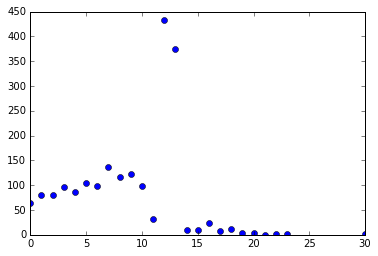

In [15]:
import matplotlib.pyplot as plt

plt.plot(graph3.rdd.map(lambda row: row[0]).take(30), graph3.rdd.map(lambda row: row[1]).take(30),'bo')

In [16]:
df4.groupby('dicSTscore').agg({'score': 'mean'}).orderBy(df4.dicSTscore.desc()).show()

+----------+----------+
|dicSTscore|avg(score)|
+----------+----------+
|      1751|       1.0|
|      1436|       4.0|
|      1252|       0.0|
|      1141|       0.0|
|      1132|     116.0|
|      1110|      19.0|
|      1094|       5.0|
|      1059|      27.0|
|       999|       8.0|
|       993|      28.0|
|       992|       3.0|
|       982|      24.0|
|       978|       0.0|
|       976|       7.0|
|       957|      19.0|
|       953|       2.0|
|       949|       2.5|
|       920|       2.0|
|       913|       2.0|
|       903|       5.0|
+----------+----------+
only showing top 20 rows



In [17]:
graph4 = df4.groupby('dicSTscore').agg({'score': 'mean'}).orderBy(df4.dicSTscore.asc())

graph4.show()

+----------+------------------+
|dicSTscore|        avg(score)|
+----------+------------------+
|         0|31.927981993015674|
|         1| 90.23416858690538|
|         2|129.28186537208666|
|         3|133.10744016649323|
|         4|140.61025898918783|
|         5| 135.1837462643401|
|         6|147.31112927394088|
|         7|120.55985037406484|
|         8|140.25817267393126|
|         9|138.52152878567972|
|        10|136.78521126760563|
|        11| 158.3596779003877|
|        12|193.80039853869147|
|        13|153.82029892248872|
|        14|161.10995542347698|
|        15|210.98159765788373|
|        16|152.01908065915003|
|        17| 197.8642634623943|
|        18|182.99157303370785|
|        19|233.05836575875486|
+----------+------------------+
only showing top 20 rows



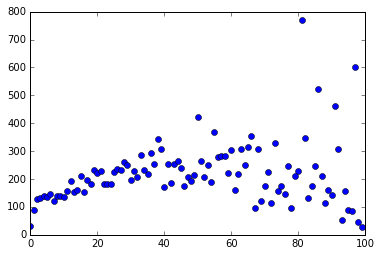

In [19]:
import matplotlib.pyplot as plt

plt.plot(graph4.rdd.map(lambda row: row[0]).take(100), graph4.rdd.map(lambda row: row[1]).take(100),'bo')

In [20]:
import json
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.regression import LinearRegressionWithSGD
import matplotlib.pyplot as plt
from pyspark.mllib.util import MLUtils
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.feature import StandardScaler
from pyspark.sql import Row
from pandas import *

from pyspark.sql.types import *  

print("START...............................................\n")

data2 = df4.rdd.filter(lambda x: x[0] is not None)

features = data2.map(lambda row: row[1:])

print(data2.take(20),"\n",features.take(5),"\n")

standardizer = StandardScaler()
model = standardizer.fit(features)
features_transform = model.transform(features)

print(features_transform.take(5),"\n")

pairFeatures_transform = features.zip(features_transform)
df_pairFeatures_transform = pairFeatures_transform.map(lambda line: Row(score = line[0],  transformation = line[1])).toDF()

print(df_pairFeatures_transform.show(10),"\n")

lab = data2.map(lambda row: row[0])

print(lab.take(5),"\n")

transformedData = lab.zip(features_transform)

print(transformedData.take(10),"\n")

print("*********************TRANSFORMED AND WITH LABELED POINT*************************\n")

transformedData_labeled = transformedData.map(lambda row: LabeledPoint(row[0],[row[1]]))
print(transformedData_labeled.take(5),"\n")

trainingData, testingData = transformedData_labeled.randomSplit([.8,.2],seed=1234)

numIterations = 100
stepSize = 0.2

print(testingData.take(10),"\n")

START...............................................

[Row(score=14, dicTscore=1, dicSTscore=21), Row(score=0, dicTscore=2, dicSTscore=2), Row(score=40, dicTscore=1, dicSTscore=5), Row(score=0, dicTscore=2, dicSTscore=0), Row(score=16, dicTscore=4, dicSTscore=2), Row(score=0, dicTscore=3, dicSTscore=5), Row(score=0, dicTscore=1, dicSTscore=1), Row(score=0, dicTscore=1, dicSTscore=0), Row(score=0, dicTscore=2, dicSTscore=1), Row(score=0, dicTscore=1, dicSTscore=2), Row(score=46, dicTscore=4, dicSTscore=0), Row(score=0, dicTscore=2, dicSTscore=1), Row(score=0, dicTscore=1, dicSTscore=4), Row(score=59, dicTscore=2, dicSTscore=1), Row(score=60, dicTscore=0, dicSTscore=8), Row(score=48, dicTscore=1, dicSTscore=24), Row(score=0, dicTscore=2, dicSTscore=5), Row(score=0, dicTscore=1, dicSTscore=4), Row(score=55, dicTscore=1, dicSTscore=33), Row(score=9, dicTscore=0, dicSTscore=7)] 
 [(1, 21), (2, 2), (1, 5), (2, 0), (4, 2)] 

[DenseVector([0.5964, 1.2728]), DenseVector([1.1928, 0.1212]), Dense

In [21]:
linearModel = LinearRegressionWithSGD.train(trainingData,numIterations,stepSize)

print("MODEL TRAINED\n")

/opt/spark/python/pyspark/mllib/regression.py:281: UserWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.")


MODEL TRAINED



In [74]:
transformation_factor = 1.85870302384270

print("***************************************** PREDICTION ******************************************\n")

print(linearModel.predict([0*transformation_factor,1*transformation_factor]),"\n")

***************************************** PREDICTION ******************************************

76.70244997237006 



In [23]:
print("0,0",linearModel.predict([0*transformation_factor,0*transformation_factor]),"\n")
print("0,1",linearModel.predict([0*transformation_factor,1*transformation_factor]),"\n")
print("1,0",linearModel.predict([1*transformation_factor,0*transformation_factor]),"\n")
print("1,1",linearModel.predict([1*transformation_factor,1*transformation_factor]),"\n")
print("0,2",linearModel.predict([0*transformation_factor,2*transformation_factor]),"\n")
print("2,1",linearModel.predict([2*transformation_factor,1*transformation_factor]),"\n")
print("1,2",linearModel.predict([1*transformation_factor,2*transformation_factor]),"\n")
print("2,2",linearModel.predict([2*transformation_factor,2*transformation_factor]),"\n")
print("2,3",linearModel.predict([2*transformation_factor,3*transformation_factor]),"\n")
print("0,3",linearModel.predict([0*transformation_factor,3*transformation_factor]),"\n")
print("2,5",linearModel.predict([2*transformation_factor,5*transformation_factor]),"\n")


0,0 0.0 

0,1 76.70244997237006 

1,0 72.23750135398124 

1,1 148.93995132635132 

0,2 153.40489994474012 

2,1 221.17745268033255 

1,2 225.64240129872138 

2,2 297.87990265270264 

2,3 374.58235262507264 

0,3 230.10734991711018 

2,5 527.9872525698129 



In [75]:
df4.filter(df4['dicTscore'] == '0').filter(df4['dicSTscore'] =='1').groupby('dicSTscore').agg({'score': 'mean'}).orderBy(df4.dicSTscore.asc()).show()


+----------+-----------------+
|dicSTscore|       avg(score)|
+----------+-----------------+
|         1|68.33919156414763|
+----------+-----------------+



In [40]:
i=0
errors = []
while i<5:
    a = linearModel.predict([0*transformation_factor,i*transformation_factor])
    b = df4.filter(df4['dicTscore'] == '0').filter(df4['dicSTscore'] == i).groupby('dicSTscore').agg({'score': 'mean'}).orderBy(df4.dicSTscore.asc())
#print(type(a))
#print(type(b))
    print(b.show())
    print("\n PREDICTED",a)
    error = b.withColumn('error', (b['avg(score)'] -a)).select('error')
    print(error.show())
    i=i+1

+----------+------------------+
|dicSTscore|        avg(score)|
+----------+------------------+
|         0|23.537689087500322|
+----------+------------------+

None

 PREDICTED 0.0
+------------------+
|             error|
+------------------+
|23.537689087500322|
+------------------+

None
+----------+-----------------+
|dicSTscore|       avg(score)|
+----------+-----------------+
|         1|68.33919156414763|
+----------+-----------------+

None

 PREDICTED 76.70244997237006
+------------------+
|             error|
+------------------+
|-8.363258408222435|
+------------------+

None
+----------+------------------+
|dicSTscore|        avg(score)|
+----------+------------------+
|         2|119.58693304535637|
+----------+------------------+

None

 PREDICTED 153.40489994474012
+------------------+
|             error|
+------------------+
|-33.81796689938375|
+------------------+

None
+----------+-----------------+
|dicSTscore|       avg(score)|
+----------+-----------------+
|   

In [67]:
j=0
errors = []
while j<10:
    i=0
    while i<10:
        a = linearModel.predict([j*transformation_factor,i*transformation_factor])
        b = df4.filter(df4['dicTscore'] == j).filter(df4['dicSTscore'] == i).groupby('dicSTscore').agg({'score': 'mean'}).orderBy(df4.dicSTscore.asc())
        error_df = b.withColumn('error', (b['avg(score)'] -a)).select('error')
        error_p = error_df.toPandas()
        e = error_p.values.tolist()
        errors.append(e)
        i = i + 1
        print("\nround ",i,j)
    j = j + 1
print("\n",errors)


round  1 0
[[[23.537689087500322]]]

round  2 0
[[[23.537689087500322]], [[-8.363258408222435]]]

round  3 0
[[[23.537689087500322]], [[-8.363258408222435]], [[-33.81796689938375]]]

round  4 0
[[[23.537689087500322]], [[-8.363258408222435]], [[-33.81796689938375]], [[-155.83394167740983]]]

round  5 0
[[[23.537689087500322]], [[-8.363258408222435]], [[-33.81796689938375]], [[-155.83394167740983]], [[-245.78058948327305]]]

round  6 0
[[[23.537689087500322]], [[-8.363258408222435]], [[-33.81796689938375]], [[-155.83394167740983]], [[-245.78058948327305]], [[-327.0582268733446]]]

round  7 0
[[[23.537689087500322]], [[-8.363258408222435]], [[-33.81796689938375]], [[-155.83394167740983]], [[-245.78058948327305]], [[-327.0582268733446]], [[-385.36530224385893]]]

round  8 0
[[[23.537689087500322]], [[-8.363258408222435]], [[-33.81796689938375]], [[-155.83394167740983]], [[-245.78058948327305]], [[-327.0582268733446]], [[-385.36530224385893]], [[-454.19920108864164]]]

round  9 0
[[[23.53


round  6 2
[[[23.537689087500322]], [[-8.363258408222435]], [[-33.81796689938375]], [[-155.83394167740983]], [[-245.78058948327305]], [[-327.0582268733446]], [[-385.36530224385893]], [[-454.19920108864164]], [[-554.6170552496984]], [[-602.7802670215256]], [[-39.59608368341077]], [[-64.019640916932]], [[-109.60226875085688]], [[-183.4406373074777]], [[-284.22262919502555]], [[-344.70495838268494]], [[-403.04669755372595]], [[-467.0298898620356]], [[-545.1060030363092]], [[-659.0110242422269]], [[-114.56208664924972]], [[-133.53384338476246]], [[-174.0502086907506]], [[-240.32469021122898]], [[-300.32706328990713]], [[-345.6856652682256]]]

round  7 2
[[[23.537689087500322]], [[-8.363258408222435]], [[-33.81796689938375]], [[-155.83394167740983]], [[-245.78058948327305]], [[-327.0582268733446]], [[-385.36530224385893]], [[-454.19920108864164]], [[-554.6170552496984]], [[-602.7802670215256]], [[-39.59608368341077]], [[-64.019640916932]], [[-109.60226875085688]], [[-183.4406373074777]], [


round  7 3
[[[23.537689087500322]], [[-8.363258408222435]], [[-33.81796689938375]], [[-155.83394167740983]], [[-245.78058948327305]], [[-327.0582268733446]], [[-385.36530224385893]], [[-454.19920108864164]], [[-554.6170552496984]], [[-602.7802670215256]], [[-39.59608368341077]], [[-64.019640916932]], [[-109.60226875085688]], [[-183.4406373074777]], [[-284.22262919502555]], [[-344.70495838268494]], [[-403.04669755372595]], [[-467.0298898620356]], [[-545.1060030363092]], [[-659.0110242422269]], [[-114.56208664924972]], [[-133.53384338476246]], [[-174.0502086907506]], [[-240.32469021122898]], [[-300.32706328990713]], [[-345.6856652682256]], [[-466.74039124741705]], [[-584.3066640088058]], [[-655.3777150697044]], [[-681.2984426353821]], [[-184.23386406643465]], [[-198.67519809340178]], [[-208.0185173791249]], [[-303.4401974990182]], [[-310.73142648717965]], [[-449.21521876288824]], [[-489.05771536000884]]]

round  8 3
[[[23.537689087500322]], [[-8.363258408222435]], [[-33.81796689938375]]


round  6 4
[[[23.537689087500322]], [[-8.363258408222435]], [[-33.81796689938375]], [[-155.83394167740983]], [[-245.78058948327305]], [[-327.0582268733446]], [[-385.36530224385893]], [[-454.19920108864164]], [[-554.6170552496984]], [[-602.7802670215256]], [[-39.59608368341077]], [[-64.019640916932]], [[-109.60226875085688]], [[-183.4406373074777]], [[-284.22262919502555]], [[-344.70495838268494]], [[-403.04669755372595]], [[-467.0298898620356]], [[-545.1060030363092]], [[-659.0110242422269]], [[-114.56208664924972]], [[-133.53384338476246]], [[-174.0502086907506]], [[-240.32469021122898]], [[-300.32706328990713]], [[-345.6856652682256]], [[-466.74039124741705]], [[-584.3066640088058]], [[-655.3777150697044]], [[-681.2984426353821]], [[-184.23386406643465]], [[-198.67519809340178]], [[-208.0185173791249]], [[-303.4401974990182]], [[-310.73142648717965]], [[-449.21521876288824]], [[-489.05771536000884]], [[-610.163532373207]], [[-533.2333384088054]], [[-640.4848849391021]], [[-254.38927


round  3 5
[[[23.537689087500322]], [[-8.363258408222435]], [[-33.81796689938375]], [[-155.83394167740983]], [[-245.78058948327305]], [[-327.0582268733446]], [[-385.36530224385893]], [[-454.19920108864164]], [[-554.6170552496984]], [[-602.7802670215256]], [[-39.59608368341077]], [[-64.019640916932]], [[-109.60226875085688]], [[-183.4406373074777]], [[-284.22262919502555]], [[-344.70495838268494]], [[-403.04669755372595]], [[-467.0298898620356]], [[-545.1060030363092]], [[-659.0110242422269]], [[-114.56208664924972]], [[-133.53384338476246]], [[-174.0502086907506]], [[-240.32469021122898]], [[-300.32706328990713]], [[-345.6856652682256]], [[-466.74039124741705]], [[-584.3066640088058]], [[-655.3777150697044]], [[-681.2984426353821]], [[-184.23386406643465]], [[-198.67519809340178]], [[-208.0185173791249]], [[-303.4401974990182]], [[-310.73142648717965]], [[-449.21521876288824]], [[-489.05771536000884]], [[-610.163532373207]], [[-533.2333384088054]], [[-640.4848849391021]], [[-254.38927


round  10 5
[[[23.537689087500322]], [[-8.363258408222435]], [[-33.81796689938375]], [[-155.83394167740983]], [[-245.78058948327305]], [[-327.0582268733446]], [[-385.36530224385893]], [[-454.19920108864164]], [[-554.6170552496984]], [[-602.7802670215256]], [[-39.59608368341077]], [[-64.019640916932]], [[-109.60226875085688]], [[-183.4406373074777]], [[-284.22262919502555]], [[-344.70495838268494]], [[-403.04669755372595]], [[-467.0298898620356]], [[-545.1060030363092]], [[-659.0110242422269]], [[-114.56208664924972]], [[-133.53384338476246]], [[-174.0502086907506]], [[-240.32469021122898]], [[-300.32706328990713]], [[-345.6856652682256]], [[-466.74039124741705]], [[-584.3066640088058]], [[-655.3777150697044]], [[-681.2984426353821]], [[-184.23386406643465]], [[-198.67519809340178]], [[-208.0185173791249]], [[-303.4401974990182]], [[-310.73142648717965]], [[-449.21521876288824]], [[-489.05771536000884]], [[-610.163532373207]], [[-533.2333384088054]], [[-640.4848849391021]], [[-254.3892


round  6 6
[[[23.537689087500322]], [[-8.363258408222435]], [[-33.81796689938375]], [[-155.83394167740983]], [[-245.78058948327305]], [[-327.0582268733446]], [[-385.36530224385893]], [[-454.19920108864164]], [[-554.6170552496984]], [[-602.7802670215256]], [[-39.59608368341077]], [[-64.019640916932]], [[-109.60226875085688]], [[-183.4406373074777]], [[-284.22262919502555]], [[-344.70495838268494]], [[-403.04669755372595]], [[-467.0298898620356]], [[-545.1060030363092]], [[-659.0110242422269]], [[-114.56208664924972]], [[-133.53384338476246]], [[-174.0502086907506]], [[-240.32469021122898]], [[-300.32706328990713]], [[-345.6856652682256]], [[-466.74039124741705]], [[-584.3066640088058]], [[-655.3777150697044]], [[-681.2984426353821]], [[-184.23386406643465]], [[-198.67519809340178]], [[-208.0185173791249]], [[-303.4401974990182]], [[-310.73142648717965]], [[-449.21521876288824]], [[-489.05771536000884]], [[-610.163532373207]], [[-533.2333384088054]], [[-640.4848849391021]], [[-254.38927


round  1 7
[[[23.537689087500322]], [[-8.363258408222435]], [[-33.81796689938375]], [[-155.83394167740983]], [[-245.78058948327305]], [[-327.0582268733446]], [[-385.36530224385893]], [[-454.19920108864164]], [[-554.6170552496984]], [[-602.7802670215256]], [[-39.59608368341077]], [[-64.019640916932]], [[-109.60226875085688]], [[-183.4406373074777]], [[-284.22262919502555]], [[-344.70495838268494]], [[-403.04669755372595]], [[-467.0298898620356]], [[-545.1060030363092]], [[-659.0110242422269]], [[-114.56208664924972]], [[-133.53384338476246]], [[-174.0502086907506]], [[-240.32469021122898]], [[-300.32706328990713]], [[-345.6856652682256]], [[-466.74039124741705]], [[-584.3066640088058]], [[-655.3777150697044]], [[-681.2984426353821]], [[-184.23386406643465]], [[-198.67519809340178]], [[-208.0185173791249]], [[-303.4401974990182]], [[-310.73142648717965]], [[-449.21521876288824]], [[-489.05771536000884]], [[-610.163532373207]], [[-533.2333384088054]], [[-640.4848849391021]], [[-254.38927


round  6 7
[[[23.537689087500322]], [[-8.363258408222435]], [[-33.81796689938375]], [[-155.83394167740983]], [[-245.78058948327305]], [[-327.0582268733446]], [[-385.36530224385893]], [[-454.19920108864164]], [[-554.6170552496984]], [[-602.7802670215256]], [[-39.59608368341077]], [[-64.019640916932]], [[-109.60226875085688]], [[-183.4406373074777]], [[-284.22262919502555]], [[-344.70495838268494]], [[-403.04669755372595]], [[-467.0298898620356]], [[-545.1060030363092]], [[-659.0110242422269]], [[-114.56208664924972]], [[-133.53384338476246]], [[-174.0502086907506]], [[-240.32469021122898]], [[-300.32706328990713]], [[-345.6856652682256]], [[-466.74039124741705]], [[-584.3066640088058]], [[-655.3777150697044]], [[-681.2984426353821]], [[-184.23386406643465]], [[-198.67519809340178]], [[-208.0185173791249]], [[-303.4401974990182]], [[-310.73142648717965]], [[-449.21521876288824]], [[-489.05771536000884]], [[-610.163532373207]], [[-533.2333384088054]], [[-640.4848849391021]], [[-254.38927


round  1 8
[[[23.537689087500322]], [[-8.363258408222435]], [[-33.81796689938375]], [[-155.83394167740983]], [[-245.78058948327305]], [[-327.0582268733446]], [[-385.36530224385893]], [[-454.19920108864164]], [[-554.6170552496984]], [[-602.7802670215256]], [[-39.59608368341077]], [[-64.019640916932]], [[-109.60226875085688]], [[-183.4406373074777]], [[-284.22262919502555]], [[-344.70495838268494]], [[-403.04669755372595]], [[-467.0298898620356]], [[-545.1060030363092]], [[-659.0110242422269]], [[-114.56208664924972]], [[-133.53384338476246]], [[-174.0502086907506]], [[-240.32469021122898]], [[-300.32706328990713]], [[-345.6856652682256]], [[-466.74039124741705]], [[-584.3066640088058]], [[-655.3777150697044]], [[-681.2984426353821]], [[-184.23386406643465]], [[-198.67519809340178]], [[-208.0185173791249]], [[-303.4401974990182]], [[-310.73142648717965]], [[-449.21521876288824]], [[-489.05771536000884]], [[-610.163532373207]], [[-533.2333384088054]], [[-640.4848849391021]], [[-254.38927


round  6 8
[[[23.537689087500322]], [[-8.363258408222435]], [[-33.81796689938375]], [[-155.83394167740983]], [[-245.78058948327305]], [[-327.0582268733446]], [[-385.36530224385893]], [[-454.19920108864164]], [[-554.6170552496984]], [[-602.7802670215256]], [[-39.59608368341077]], [[-64.019640916932]], [[-109.60226875085688]], [[-183.4406373074777]], [[-284.22262919502555]], [[-344.70495838268494]], [[-403.04669755372595]], [[-467.0298898620356]], [[-545.1060030363092]], [[-659.0110242422269]], [[-114.56208664924972]], [[-133.53384338476246]], [[-174.0502086907506]], [[-240.32469021122898]], [[-300.32706328990713]], [[-345.6856652682256]], [[-466.74039124741705]], [[-584.3066640088058]], [[-655.3777150697044]], [[-681.2984426353821]], [[-184.23386406643465]], [[-198.67519809340178]], [[-208.0185173791249]], [[-303.4401974990182]], [[-310.73142648717965]], [[-449.21521876288824]], [[-489.05771536000884]], [[-610.163532373207]], [[-533.2333384088054]], [[-640.4848849391021]], [[-254.38927


round  10 8
[[[23.537689087500322]], [[-8.363258408222435]], [[-33.81796689938375]], [[-155.83394167740983]], [[-245.78058948327305]], [[-327.0582268733446]], [[-385.36530224385893]], [[-454.19920108864164]], [[-554.6170552496984]], [[-602.7802670215256]], [[-39.59608368341077]], [[-64.019640916932]], [[-109.60226875085688]], [[-183.4406373074777]], [[-284.22262919502555]], [[-344.70495838268494]], [[-403.04669755372595]], [[-467.0298898620356]], [[-545.1060030363092]], [[-659.0110242422269]], [[-114.56208664924972]], [[-133.53384338476246]], [[-174.0502086907506]], [[-240.32469021122898]], [[-300.32706328990713]], [[-345.6856652682256]], [[-466.74039124741705]], [[-584.3066640088058]], [[-655.3777150697044]], [[-681.2984426353821]], [[-184.23386406643465]], [[-198.67519809340178]], [[-208.0185173791249]], [[-303.4401974990182]], [[-310.73142648717965]], [[-449.21521876288824]], [[-489.05771536000884]], [[-610.163532373207]], [[-533.2333384088054]], [[-640.4848849391021]], [[-254.3892


round  4 9
[[[23.537689087500322]], [[-8.363258408222435]], [[-33.81796689938375]], [[-155.83394167740983]], [[-245.78058948327305]], [[-327.0582268733446]], [[-385.36530224385893]], [[-454.19920108864164]], [[-554.6170552496984]], [[-602.7802670215256]], [[-39.59608368341077]], [[-64.019640916932]], [[-109.60226875085688]], [[-183.4406373074777]], [[-284.22262919502555]], [[-344.70495838268494]], [[-403.04669755372595]], [[-467.0298898620356]], [[-545.1060030363092]], [[-659.0110242422269]], [[-114.56208664924972]], [[-133.53384338476246]], [[-174.0502086907506]], [[-240.32469021122898]], [[-300.32706328990713]], [[-345.6856652682256]], [[-466.74039124741705]], [[-584.3066640088058]], [[-655.3777150697044]], [[-681.2984426353821]], [[-184.23386406643465]], [[-198.67519809340178]], [[-208.0185173791249]], [[-303.4401974990182]], [[-310.73142648717965]], [[-449.21521876288824]], [[-489.05771536000884]], [[-610.163532373207]], [[-533.2333384088054]], [[-640.4848849391021]], [[-254.38927


round  8 9
[[[23.537689087500322]], [[-8.363258408222435]], [[-33.81796689938375]], [[-155.83394167740983]], [[-245.78058948327305]], [[-327.0582268733446]], [[-385.36530224385893]], [[-454.19920108864164]], [[-554.6170552496984]], [[-602.7802670215256]], [[-39.59608368341077]], [[-64.019640916932]], [[-109.60226875085688]], [[-183.4406373074777]], [[-284.22262919502555]], [[-344.70495838268494]], [[-403.04669755372595]], [[-467.0298898620356]], [[-545.1060030363092]], [[-659.0110242422269]], [[-114.56208664924972]], [[-133.53384338476246]], [[-174.0502086907506]], [[-240.32469021122898]], [[-300.32706328990713]], [[-345.6856652682256]], [[-466.74039124741705]], [[-584.3066640088058]], [[-655.3777150697044]], [[-681.2984426353821]], [[-184.23386406643465]], [[-198.67519809340178]], [[-208.0185173791249]], [[-303.4401974990182]], [[-310.73142648717965]], [[-449.21521876288824]], [[-489.05771536000884]], [[-610.163532373207]], [[-533.2333384088054]], [[-640.4848849391021]], [[-254.38927

In [73]:
import numpy as np
print (np.mean(errors))

-524.3420674339449
